In [ ]:
#Some pre-presentation config. I'm using a custom RISE theme called "..." 
#which is a lot like the Serif theme but with Green headers and bolding

from traitlets.config.manager import BaseJSONConfigManager
config_path = "C:\\Users\\duranl4\\AppData\\Local\\Continuum\\Anaconda2\\etc\\jupyter\\nbconfig\\"
config_path = "C:\\Anaconda2\\etc\\jupyter\\nbconfig\\"
#config_path = "C:\\Users\\duranl4\\AppData\\Local\\Continuum\\Anaconda2\\share\\jupyter\\"
cm = BaseJSONConfigManager(config_dir=config_path)
#cm = ConfigManager(profile_dir="C:\\Users\\duranl4\\AppData\\Local\\Continuum\\Anaconda2\\etc\\jupyter\\nbconfig\\")
cm.update('livereveal', {
            'theme':'serif',
        'progress': True,
        'slideNumber':True,
        'history':True,
        'scroll':True,
              'transition': 'convex',
              'start_slideshow_at': 'selected',
})

#THEMES- Black (default) - White - League - Sky - Beige - Simple - Serif - Blood - Night - Moon - Solarized
#TRANSITIONS - None - Fade - Slide - Convex - Concave - Zoom

import seaborn as sns
td_palette = ["#e8b400", "#8cc63f", "#619abc","#808083","#163d22","#00b624"]
sns.set_palette(td_palette)
import matplotlib.pyplot as plt
import numpy as np
palette = sns.color_palette()
sns.palplot(palette)
plt.show()

# Financial Models 
*Mostly Monte Carlo Methods*
<hr>
## Table of Contents
1. [Investing 101](#Investing-101)
2. [Some Math](#Some-Math)
3. [More Monte Carlo Simulations](#More-Monte-Carlo-Simulations)

<hr>
Lucas Durand, March 30 2017
<div align='right'> [<img src="https://www.continuum.io/sites/default/files/logo_jupyter.png" width = '50px' align=çenter>](http://jupyter.org/) [RISE (react.js)](http://bollwyvl.github.io/live_reveal/#/) </div>

## Some Dependencies

In [57]:
import numpy as np #arrays and math stuff
import matplotlib.pyplot as plt #for plotting
import seaborn #prettifies the matplotlib library
import sobol_seq #contains Sobols Sequence sampling
import time #why not
import pandas as pd # PANDAS!
from yahoo_finance import Share
from yahoo_finance import Currency
import scipy
import math
import matplotlib.animation as animation
from matplotlib import rc
from colour import Color
#Major Key: turn on in-line visualisation
%matplotlib nbagg 
present = True

# Investing 101

1. [Savings Accounts](#Savings-Accounts)
2. [Stocks, Bonds, ETFs](#Stocks,-Bonds,-ETFs)
    1. [Toy Model](#Toy-Model)
3. [Options](#Options)


## Savings Accounts

How do savings accounts work? 
- Put money in with the intention of aggregating funds for a guaranteed return. 
- Presumably, the bank takes that money and uses it for another endeavour which nets a higher return.
    - e.g. pay 0.05% interest to savings account, loan money as mortgage at 5%

How much money can we make with savings accounts?? 

### Future Value

In the case of a **fixed rate of interest**, we have a closed-form solution for what the **future value** of money is worth over time.

> $FV = C (1+r)^n$, given a present cash flow $C$, rate of interest $r$ and number of compoundings $n$. 

This also generalizes into a continuous form:
> $FV = C e^{rt}$, for a cashflow at time $t$
 
So we can plot this, use it in equations, etc. in order to inform our decisions.



#### Three Savings Strategies

In [1]:
t_end = 5 #calculate until
t_f = 5 #expiry time

t = np.linspace(0,t_end,261*t_end)
r_tdeveryday = 0.05 * 0.01 #Entry-level Savings Account interest rate
r_tdhighint = 0.5* 0.01 #High Interest Savings Account interest rate
r_tdgic = 1.0 * 0.01 #Special GIC interest rate
c= 1000 #starting with $1000

def fv(t,r,c=c): #future value equation
    return c*np.exp(r*t)

lines = [{'label':'Everyday Savings Account (TD)','vals':fv(t,r=r_tdeveryday),'y_int':fv(t_f,r=r_tdeveryday)},\
        {'label':'High Interest Savings Accounts (TD)','vals':fv(t,r=r_tdhighint),'y_int':fv(t_f,r=r_tdhighint)},\
         {'label':'Special Offer GIC (TD)','vals':fv(t,r=r_tdgic),'y_int':fv(t_f,r=r_tdgic)}]


NameError: name 'np' is not defined

In [ ]:
def future_savings():
    fig,ax = plt.subplots()
    ax.set_title('FV of $%s in %s years'%(c,t_f))
    for line in lines:
        ax.plot(t,line['vals'],label=line['label'])
        ax.axhline(line['y_int'], linestyle='--', color=palette[2]) # horizontal lines
    ax.axvline(t_f, linestyle='--',color=palette[2]) # vertical lines
    #ax.legend(frameon=True,fancybox=True,loc="best",shadow=True)
    ax.legend(loc="best")
 
    ax.fill_between(t, c, lines[0]['vals'],color=palette[0],alpha=0.5)
    ax.fill_between(t, lines[0]['vals'], lines[1]['vals'],color=palette[1],alpha=0.5)
    ax.fill_between(t, lines[1]['vals'], lines[2]['vals'],color=palette[2],alpha=0.5)
    plt.show()

Safe Investments

<IPython.core.display.Javascript object>


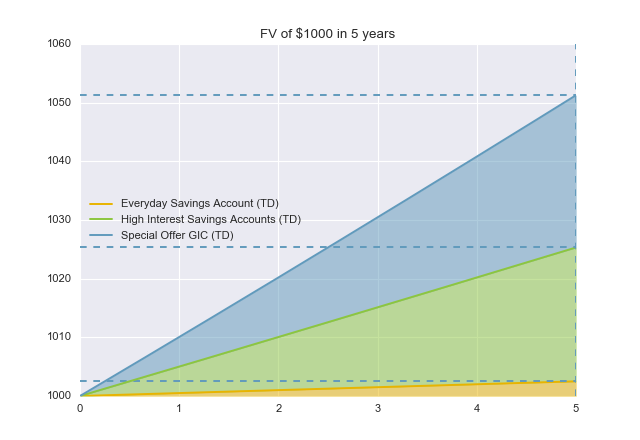

In [55]:
future_savings()

<br/>
<br/>
<br/>
<br/>
<br/>

## Stocks, Bonds, ETFs

Stocks
- Buy a share of a company!
- Value tied to perceived value of company
    - e.g. Alice **bids** 9 for XYZ and Bob **asks** 11 
    - $\implies$ XYZ $\approx$ 10
- A stock is a winner if it outperforms our savings account (or some index)

Bonds
- Loan money to a stranger!
    - Government or Corporation (*but really what's the difference?*)
- Pays back initial investment at expiry time, and pays **coupons** at regular intervals
- Coupons can be **variable rate** (tied to an overnight lending rate like LIBOR or fixed rate)
- We won't talk about these any more


ETFs
- Throw your money at a pile of money!
- Essentially a *stock of stocks*, an instrument bought and sold on a market that tracks an index/indicator
- e.g. S&P 500 [^GSPC], TSX Composite [^TSX]

How can we predict the future value of Stocks & ETFs?

### Toy Model

- Every day the instrument price **randomly** changes
- Changes lie on a **log normal distribution** (strictly positive prices)
- The distribution has mean **$\mu$** and standard deviation **$\sigma$** equal to the historical mean and volatility of the stock.

Load Historical Data

In [59]:
symbol = "^GSPC"
start = '2016-01-01'
end = '2017-03-10'
def get_history(symbol=symbol, start=start, end=end):
    share = Share(symbol) #Yahoo API for historical data
    old = share.get_historical(start,end) #fit this to lognormal dist and return mean/vol
 
    history = np.array([float(x['Close']) for x in old]) #get closing price
    history = history[::-1] #sort from old to new
    
    # Mean and volatility
    mean = ((pd.DataFrame(history).pct_change()).loc[1:] + 1).mean() #average daily change multiplier
    vol = ((pd.DataFrame(history).pct_change()).loc[1:] + 1).std() 
    return history, mean, vol
history, mean, vol = get_history()

In [ ]:
def gen_runs(N,mean,vol,history,t_end):
    cumr = np.empty((N,t_end*261))
    t_days = np.linspace(0,t_end,len(cumr[0]))
    for i in range(N):
        r = np.log(np.random.lognormal(mean,vol, t_end*261-1))
        r = np.insert(r,0,c)
        cumr[i] = np.cumprod(r)
    return cumr, t_days

def mc_runs(N,history,mean,vol,t_end):
    cumr, t_days = gen_runs(N,mean,vol,history,t_end)
    length = min(len(history),len(cumr[0]))
    fig, ax = plt.subplots()
    #prediction
    for run in cumr[:N]:
        plt.plot(t_days[:length],run[:length],alpha=0.5)
    plt.plot(t_days[:length],np.median(cumr,axis=0)[:length],color='black',label="Median Path")
    #history
    plt.plot(t_days[:length],history[:length]*c/history[0],color='r', label="Historical Path")
    ax.legend(loc="best")
    ax.set_xlabel('Years')
    plt.show()
    return cumr, t_days

#### A Single, Solitary Run

<IPython.core.display.Javascript object>


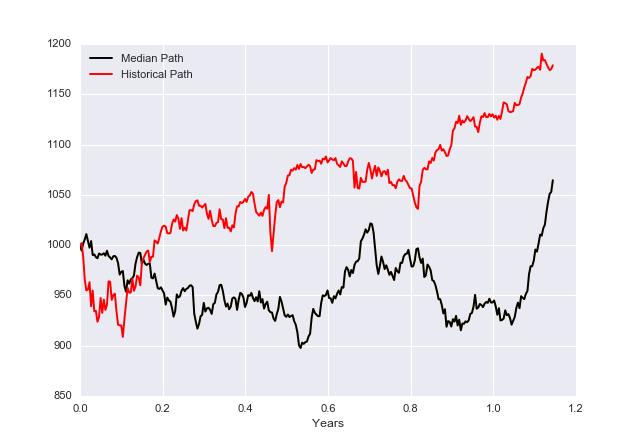

In [61]:
cumr, t_days = mc_runs(N=1,mean=mean,vol=vol,history=history,t_end=2) 

<br/>
<br/>
<br/>
<br/>
<br/>

This is one possible future. But what other possible futures are there?

#### Many Possible Paths

<IPython.core.display.Javascript object>


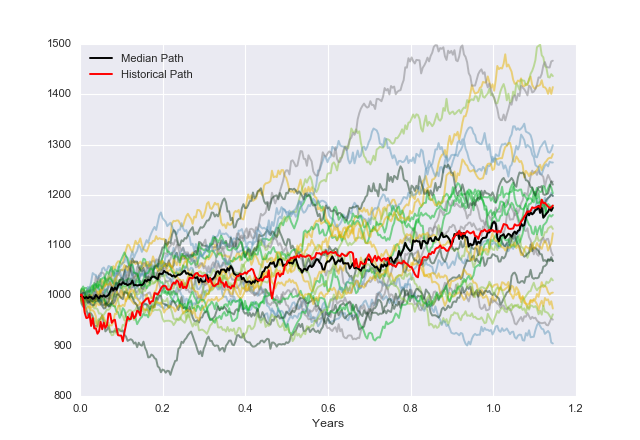

In [62]:
cumr, t_days = mc_runs(N=25,mean=mean,vol=vol,history=history,t_end=2)  

<br/>
<br/>
<br/>
<br/>
<br/>

We just did a Monte Carlo!

#### Percentile Binning

In [ ]:
bands = [(5,95),(25,75),(1,99)]
def end_plot(run_data,historical_data,names=[],strike=0, bands = bands,t_f=t_f, expiry=0, title='',callput='',hist=False): #t_f should be a 
    fig,axs = plt.subplots(len(run_data),sharex=True)
    fig.suptitle(title)
    for i in range(len(run_data)):
        cumr, t_days = run_data[i]
        
        if len(run_data) > 1:
            ax = axs[i]
        else:
            ax = axs
        t_f = int(t_f)
        mask = (t_days <= t_f)
        t=t_days
        if len(names)>0 and i < len(names):
            ax.set_title(names[i])
        elif i == 0:
            ax.set_title('FV of $%s in %s years'%(c,t_f))

        ax.plot(t[mask],np.median(cumr,axis=0)[mask],color=palette[4], label=symbol+" Prediction")

        bands.sort()
        bands = bands[::-1]
        for band in bands: #percentile bands
            bottom = np.percentile(cumr,band[0],axis=0)[mask]
            top = np.percentile(cumr,band[1],axis=0)[mask]
            ax.fill_between(t[mask], bottom, top,color = palette[4],alpha=1./len(bands))
        ax.set_ylim(bottom.min(),top.max())
        if strike == 0 and len(run_data)==1: #draw Savings Account curves
            for line in lines:
                ax.plot(t[mask],line['vals'][mask],label=line['label'])
            ax.fill_between(t[mask], lines[1]['vals'][mask], lines[2]['vals'][mask],color = palette[2],alpha=0.5)
            ax.fill_between(t[mask], lines[0]['vals'][mask], lines[1]['vals'][mask],color = palette[1],alpha=0.5)
            ax.fill_between(t[mask], c, lines[0]['vals'][mask],color = palette[0],alpha=0.5)
        elif strike > 0: #plot Strike price and money
            ax.axhline(strike,0,1.*expiry/t_f,color=palette[0], label="Strike")

            expiration = (t <= expiry)
            if callput == "call":
                ax.fill_between(t[expiration],strike, top.max(),color=palette[0],alpha=0.2, label="The Money")
                #ax.axvline(1.*expiry/t_f,(strike-bottom.min())/(top.max()-bottom.min()),1,color=palette[0], linestyle = '--')
            elif callput == "put":
                ax.fill_between(t[expiration],strike, bottom.min(),color=palette[0],alpha=0.2, label="The Money")
                #ax.axvline(1.*expiry/t_f,0,(strike-bottom.min())/(top.max()-bottom.min()),color=palette[0],linestyle='--')
        if hist: #plot historical path
            history = historical_data[i]
            length = min(len(history),list(mask).count(True))
            ax.plot(t_days[:length],history[:length]*c/history[0],color='r', label="Historical Path")
        ax.legend(loc="best")
    if len(run_data) > 1:
        lims = zip(*([ax.get_ylim() for ax in axs]))
        newlims = [ax.set_ylim(min(lims[0]),max(lims[1])) for ax in axs]
    
    plt.show()

<IPython.core.display.Javascript object>


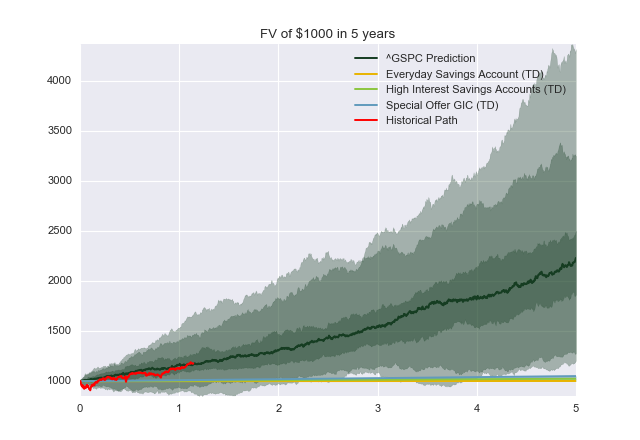

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:31: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1305 but corresponding boolean dimension is 2610
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:32: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1305 but corresponding boolean dimension is 2610
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:33: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1305 but corresponding boolean dimension is 2610
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1305 but corresponding boolean dimension is 2610


In [65]:
run_data = gen_runs(50,mean,vol,history,t_end) 
end_plot([run_data],[history],t_f = 5,hist=True)

<br/>
<br/>
<br/>
<br/>
<br/>

## Options


A type of derivative that allows the holder the right to buy **(call)** or sell **(put)** the underlying asset at (or before) a future date (the **expiry**) at a predetermined price (the **strike price**)

The value of an option is equal to the difference between the strike price and the value of the underlying.

> $Put = \max(\text{Strike} - V(t),0)$

> $Call = \max(V(t)- \text{Strike},0)$


Options

<IPython.core.display.Javascript object>


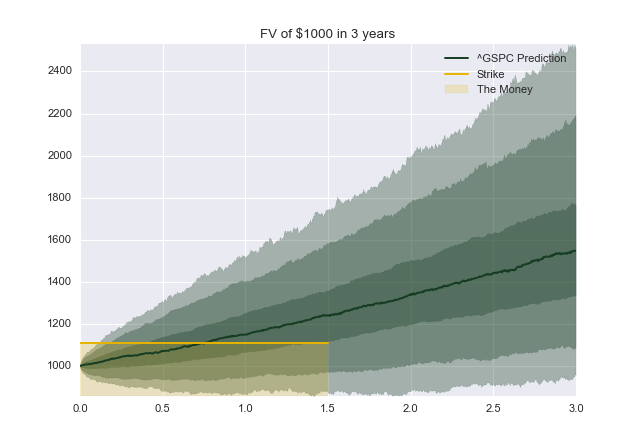

In [66]:
run_data = gen_runs(1000,mean,vol,history,t_end)
end_plot([run_data],[history], strike = 1110, expiry = 1.5 ,t_f = 3, callput='put')
#end_plot( strike = 1010, expiry = 0.5 ,t_f = 0.6, callput='put') 

<br/>
<br/>
<br/>
<br/>
<br/>

# Some Math

1. Law of Large Numbers
2. Central Limit Theorem
1. Random Numbers

### Law of Large Numbers

> Performing the same experiment many times, the average of the outcomes approaches the expected value

### Central Limit Theorem

> The average of many independent variables tends toward a normal distribution

# Random Numbers
*What are they?*

Mathematically, $n \subset [0,1]$ is a sequence of **random numbers** iff:
1. $P(n_i) = P(n_j) \quad \forall i,j \qquad$ **Uniform Distribution**
2. $P(n_i) = P(n_i|n_{i-1}) \qquad$ **Numbers are Independent**

## Why are they important?

Two big uses for random numbers are:

* Stochastic Approximations (e.g. Monte Carlo Methods!)
* Cryptography (e.g. Public/Private Key Generation)
* Winning at Rock, Paper, Scissors

## How do we make them?
Not very well.

* Slowly, using random physical phenomena 
    * e.g. Photon phase shifts, thermal CPU noise, ...
    * These are "truly" random (depending who you ask)

* Quickly, with pseudo-random number generation:
    * $X_{n+1} = (a X_n + b)\ \text{mod} \ m $, where $a,b,m$ are large seed values
    * These (like those used in RAS keys) are fully deterministic with the right knowledge (i.e. #2 is broken)

In [67]:
np.random.random(10)

array([ 0.33737726,  0.10810893,  0.75107931,  0.56822741,  0.15841138,
        0.59916281,  0.8135214 ,  0.12495449,  0.76135713,  0.46046854])

In [ ]:
N=250 # How many points?
more = 100
def random_plot2d(N=N,more=more):
    fig, ax = plt.subplots(1,1) #Create a figure and set of axes
    ax.set_xlim([0,1]) #some limits on axes
    ax.set_ylim([0,1])

    plt.ion() #interactive mode on
    plt.show() #show the plot

    xs=[] #initialize some lists
    ys=[]
    for n in np.arange(N): #gonna plot N points
        xs += [np.random.random()] #random numbers for x and y
        ys += [np.random.random()]
        time.sleep(0.0001) #chill out for a second so windows doesn't die
        ax.set_title(str(n+1)+' Random Points!')
        ax.plot(xs,ys, marker='o',ms=7, linestyle= 'None', color=palette[1])
        fig.canvas.draw()  #re-fresh the plot
    plt.ioff()  
    plt.show()   
    if present:
        wait = raw_input("Press Enter to continue...")
    ax.set_title(str(more*N)+' Random Points! Gee, that\'s a lot!')
    xs += list(np.random.random((more-1)*N))
    ys += list(np.random.random((more-1)*N))
    ax.plot(xs,ys, marker='o',ms=3, color=palette[1],linestyle= 'None')





Random Points in 2D

<IPython.core.display.Javascript object>


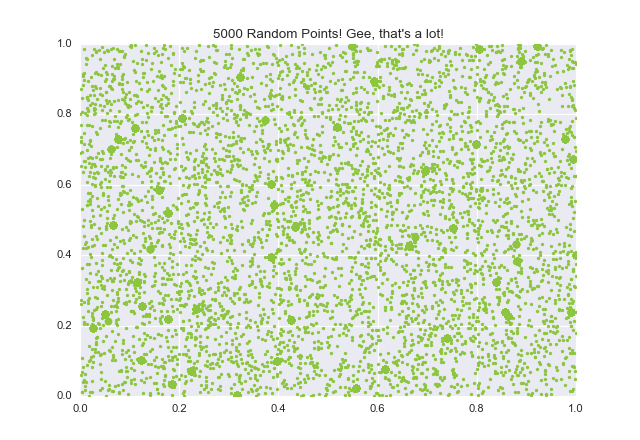

Press Enter to continue...


In [68]:
random_plot2d(50)

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

In [ ]:
def random_plots(N,ncols=5,nrows=3):
    # create the plots
    fig = plt.figure()
    axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

    # add some data
    for i,ax in enumerate(axes):
        ax.plot(np.random.random(N), np.random.random(N), '.', color=palette[i%6])

    # remove the x and y ticks
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

Many Small Random Samples
- Clumping is noticable
- Space not well filled without large number of points

<IPython.core.display.Javascript object>


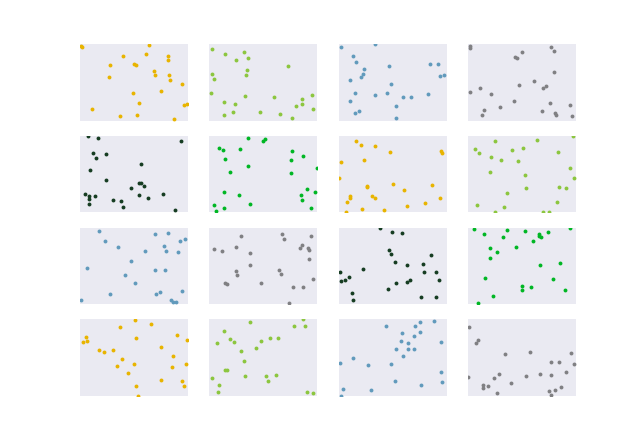

In [69]:
random_plots(25,4,4)
plt.show()

<br/>
<br/>
<br/>
<br/>
<br/>

# Sobol Sequence

* Sequence of numbers which better "fill" the parameter space
* Defined for *fastest* convergence
* Fall apart in large-dimensioned problems (we don't mind)

What could that mean?

Let's see!

In [70]:
sobols = [(x,y) for x,y in sobol_seq.i4_sobol_generate(2, more*N)]
sobols[:5]

[(0.5, 0.5), (0.75, 0.25), (0.25, 0.75), (0.375, 0.375), (0.875, 0.875)]

### Huh?

... let's see it plotted

In [ ]:
def sobol_plot2d(N=N,more=more,sobols=sobols):
    if N*more > len(sobols):
        sobols = [(x,y) for x,y in sobol_seq.i4_sobol_generate(2, more*N)]
    fig, ax = plt.subplots(1,1) #Create a figure and set of axes
    ax.set_xlim([0,1]) #some limits on axes
    ax.set_ylim([0,1])

    plt.ion() #interactive mode on
    plt.show() #show the plot

    xs = [x[0] for x in sobols]
    ys = [x[1] for x in sobols]
    for n in np.arange(N): #gonna plot N points
        print '\r'+str(n),
        time.sleep(0.0001) #chill out for a second so windows doesn't die
        ax.set_title(str(n)+' Sobol Points!')
        ax.plot(xs[:n],ys[:n], marker='o',ms=7, color=palette[1],linestyle= 'None')
        fig.canvas.draw()  #re-fresh the plot

    plt.ioff()  
    plt.show()
    if present:
        wait = raw_input("Press Enter to continue...")
    ax.set_title(str(more*N)+' Sobol Points! Zow-ee!')
    ax.plot(xs,ys, marker='o',ms=3, color=palette[1],linestyle= 'None')




Sobol Points in 2D

<IPython.core.display.Javascript object>


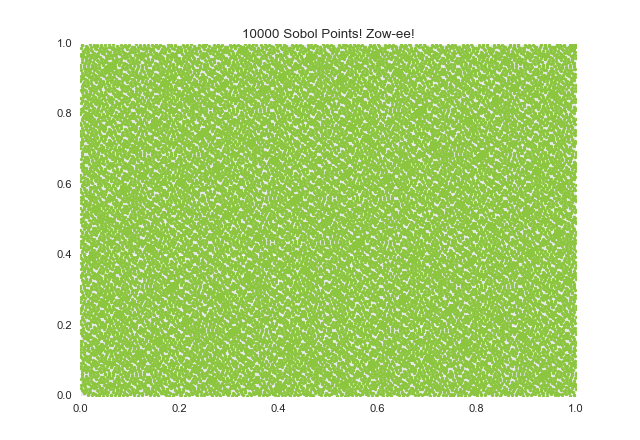

99Press Enter to continue...



In [72]:
sobol_plot2d(100)

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

# More Monte Carlo Simulations

1. [Estimate $\pi$](#Estimate-Pi)
2. [Gamble Winningly](#Gamble-Winningly)
3. [An Argument for Public Transit](#Relive-Traffic-Nightmares)
2. [Toy Model Again](#Toy-Model-Again)


## What is it?

A Monte Carlo simulation is a numerical method that allows for the accountability of risk in quantitative analysis. By replacing fixed variables with probability distributions and randomly sampling possible outcomes, we can assign probabilities to scenarios and develop a risk profile, all while solving analytically intractable problems. 

We use them for:

   * Optimization
   * Numerical integration
   * Sampling probability distributions
    


## Estimate Pi

#### What we're doing:
1. Sample $n$ points in a 1x1 square
2. Count any points ($n_{in}$) that fall within the area of a circle,$x^2 + y^2 \leq r^2$
3. We expect that the probability of a point being in the circle, $P(\text{circle})$, to be proportional to its area, $A_\text{circle}$
4. Sample enough points that the estimation converges to some value


#### The equation:
$\frac{P(\text{Circle})}{P(\text{Square})} \sim \frac{A_\text{circ}}{A_\text{square}} = \frac{\pi r^2}{(2r)^2}  \\ 
\lim_{n\rightarrow \infty} \implies \pi \sim 4\frac{n_{in}}{n} $



![circle](https://static1.squarespace.com/static/54e50c15e4b058fc6806d068/t/54f63a69e4b02d96d056f5c5/1460531331862/basic-circle.png?format=500w)

In [73]:
def condition(x,y,r):
    return (x-r)**2 + (y-r)**2 <= r**2  #circle inscribed in square
    #return x <= r #square sliced in two
r = 1/2. #radius-type thing

sobol = False #Use a Sobol Sequence?
N = 100 # number of animated runs (more than 250 doesn't go well)
More = 1000 # multiplying for hidden runs --> total runs = More*N
result_width = 50 #window of results to display in animated run
mark=3 #size of dots

In [ ]:
linecol = palette[0]
circlecol = palette[2]
incol = palette[1]
outcol= palette[0]
areacol = palette[1]
#run this twice, with psuedo-random numbers and Sobol sequence
def monte_carlo():
    def get_xy(n,sobol):
        if sobol:
            x,y = sobols[n]
        else:
            y = np.random.random()
            x = np.random.random()
        return (x,y)

    def in_out(ax,i,bingo,bingout,n):  
        if n > result_width and n != More*N-1:
            inout = 1.*bingo/bingout
            start_out = (n - result_width)/(1+inout)
            start_in = inout * start_out
            ax[i].cla()
            circ=plt.Circle((r,r), radius=r, color=circlecol, fill=False)
            ax[i].add_patch(circ)
            start_in, start_out = int(start_in),int(start_out)
        else:
            start_in=0
            start_out=0
        

        ax[i].plot(xin.T[0][start_in:bingo],xin.T[1][start_in:bingo],color=incol, marker='o',ms=mark, linestyle= 'None')
        ax[i].plot(xout.T[0][start_out:bingout],xout.T[1][start_out:bingout],color=outcol, marker='o',ms=mark, linestyle= 'None')
        ax[i].set_title("Sampled Points")

    def update_area(ax,i,n,bingo,area,analytic_result,finish=False,finished=False):
        if finished:
            ax[i].cla()
            ax[i].set_xlim([1,n])
            ax[i].set_ylim([max(area.T[1].min(),2.5),area.T[1].max()])
            ax[i].set(xlabel='Number of Runs', ylabel='Running Average',title="Sampled Value")
            ax[i].plot((1, n), (analytic_result,analytic_result), color=linecol) #line at pi
            ax[i].semilogx(area.T[0][:n+1],area.T[1][:n+1],color=areacol)
            return area
        points = n+1
        #squarea = len(xin)/(1.*points)
        pi = 4*bingo/(1.*points)
        area[n] = [points,pi]
        if finish:
            return area

        if points <= result_width:
            ax[i].plot(area.T[0][:n],area.T[1][:n],color= areacol)
        else:
            ax[i].cla()
            # recompute the ax.dataLim
            #ax[i].relim()
            # update ax.viewLim using the new dataLim
            #ax[i].autoscale_view()
            ax[i].set_ylim([max(area.T[1].min(),2.5),area.T[1].max()+0.1])
            ax[i].set_xlim([points-result_width,points])
            ax[i].plot((points-result_width, points), (analytic_result,analytic_result), color=linecol) #line at pi
            ax[i].plot(area.T[0][n-result_width:n],area.T[1][n-result_width:n],color=areacol)
        ax[i].set(xlabel='Number of Runs', ylabel='Running Average',title="Sampled Value")
        return area
    
    fig, ax = plt.subplots(1,2)
    ax[0].set_xlim([0,1])
    ax[0].set_ylim([0,1])
    ax[1].set_xlim([1,result_width])
    ax[0].set(adjustable='box-forced', aspect='equal')

    plt.ion()
    plt.show()

    xin=np.empty((N*More,2))
    xout=np.empty((More*N,2))
    area=np.empty((More*N,2))
    bingo=0
    bingout=0
    #analytic_result = 0.5
    analytic_result = np.pi
    circ=plt.Circle((r,r), radius=r, color=circlecol, fill=False)
    ax[0].add_patch(circ)
    ax[1].plot((0, result_width), (analytic_result,analytic_result),color= linecol) #line at pi

    sobols = [(x,y) for x,y in sobol_seq.i4_sobol_generate(2, More*N)]

    for n in np.arange(N):
        x,y = get_xy(n,sobol)
        if condition(x,y,r):
            xin[bingo]=[x,y]
            bingo+=1
        else:
            xout[bingout] = [x,y]
            bingout += 1
        time.sleep(0.005)
        in_out(ax,0,n,bingo,bingout)
        area = update_area(ax,1,n,bingo,area,analytic_result)
        fig.canvas.draw()  # May be necessary, wasn't for me.

    plt.ioff()  
    plt.show()  
    if present:
        wait = raw_input("Press Enter to continue...")

    for n in np.arange(N,More*N):
        x,y = get_xy(n,sobol)
        if condition(x,y,r):
            xin[bingo]=[x,y]
            bingo+=1
        else:
            xout[bingout] = [x,y]
            bingout+=1
        area = update_area(ax,1,n,bingo,area,analytic_result,finish=True)
    in_out(ax,0,n,bingo,bingout)
    area = update_area(ax,1,n,bingo,area,analytic_result,finished=True)
    plt.show()
    print "Numerical Value = %s. Expected value = %s" %(area[-1,1],np.pi)
    print "Pct. Error = %s" %(abs((area[-1,1]-np.pi)/np.pi*100))


<IPython.core.display.Javascript object>


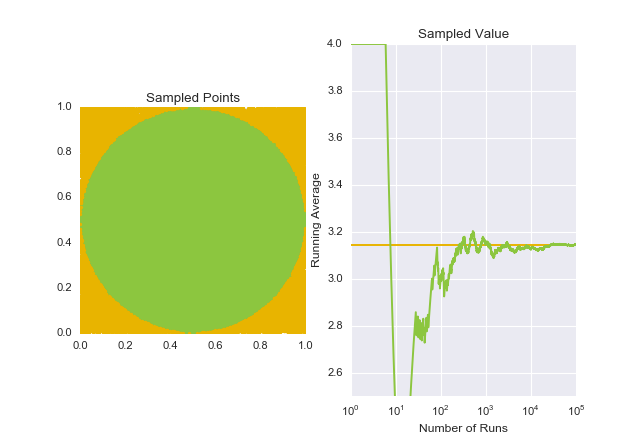

Press Enter to continue...
Numerical Value = 3.14508. Expected value = 3.14159265359
Pct. Error = 0.111005683892


In [74]:
monte_carlo()

<br/>
<br/>
<br/>
<br/>
<br/>

<IPython.core.display.Javascript object>


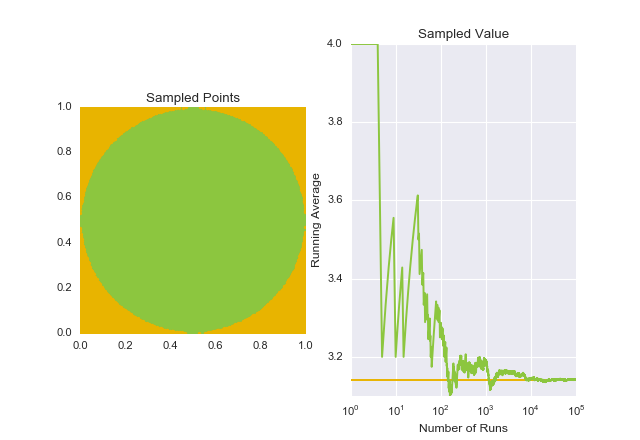

Press Enter to continue...
Numerical Value = 3.14196. Expected value = 3.14159265359
Pct. Error = 0.0116929994023


In [75]:
sobol = True #Use a Sobol Sequence?
N = 100 # number of animated runs (more than 250 doesn't go well)
More = 1000 # multiplying for hidden runs --> total runs = More*N
monte_carlo()  

<br/>
<br/>
<br/>
<br/>
<br/>

## Gamble Winningly

The Game
> Flip a coin 10 times, if you get 3 heads, you win $1,000,000

The Question
> How much would you pay to play this game?

The Answer

> The probability for $k$ heads in $n$ flips of a coin with probability $p$, we can use the **binomial equation** ...

> $P(k) = {n\choose{k}}p^k (1−p)^{n−k}$

> with expected winnings, $E(3) = V(3) P(3)$

In [76]:
E = 10**6 * np.math.factorial(10)/(np.math.factorial(3)*np.math.factorial(10-3)) * (0.5)**3 * (0.5)**7

In [ ]:
n = 10**3
headsx = scipy.linspace(0,10,11)
pmf = scipy.stats.binom.pmf(headsx,10,0.5)
def fib_formula(n):
    golden_ratio = (1 + math.sqrt(5)) / 2
    val = (golden_ratio**n - (1 - golden_ratio)**n) / math.sqrt(5)
    return int(round(val))
def show_num(num,n=n,number_of_frames=50):
    return min(fib_formula(num),n/number_of_frames)

In [ ]:
def update_hist(num, data):    
    ax.cla()
    ax.set_xlim(-1,11)
    ax.set_ylim(0,0.4)
    ax.set_xticks(range(11))
    ax.set_title(str((1+num)*show_num(num)) + " Games!")
    ax.hist(data[:((1+num)*show_num(num))],align="left", bins =headsx, normed= True)
    ax.plot(headsx,pmf,color=palette[2])
    
    ax2.cla()
    ax2.axhline(E,color=palette[1])
    expectation.loc[:((1+num)*show_num(num))].plot(x='games',y='expectation',ax=ax2)


In [ ]:
def anim_init():
    fig, (ax,ax2) = plt.subplots(1,2)
    
    ax.set_autoscale_on(False)
    ax.set_xlim(-1,11)
    ax.set_ylim(0,0.4)
    ax.set_xticks(range(11))
    ax.plot(headsx,pmf,color=palette[2])
    hist = ax.hist(data[0],align="left",bins = headsx, normed= True)
    
    ax2.set_autoscale_on(False)
    
    ax2.set_ylim(0,expectation.nlargest(3,'expectation')['expectation'].values[-1])
    ax2.axhline(E,color=palette[1])
    expectation.loc[0].plot(x='games',y='expectation',ax=ax2)
    return fig, ax, ax2

In [77]:
sobol = False
def game(gamen=0):
    heads = 0
    for n in range(10):
        if sobol:
            if sobols[n+ 10*gamen] <= 0.5:
                heads += 1
        else:
            if np.random.random() <= 0.5:
                heads += 1
    return heads
if sobol:
    sobols = [sob for sob in sobol_seq.i4_sobol_generate(1, 10*n)]

In [ ]:
def expected(data,n_winning=3,Winnings = 10**6):
    df = pd.DataFrame(data,columns=['heads'])
    df['wins'] = (df['heads'] == n_winning).expanding().sum()
    df['games'] = df.index + 1
    df['expectation'] = df['wins']*Winnings / df['games']
    return df[['games','expectation']]

## Play the Game

In [80]:
n = 10000 #number of games to play
number_of_frames = 50 #to animate game
Winnings = 10**6 #prize
n_winning = 3 #number of heads to win
#analytic solution (for comparison)
E = Winnings * np.math.factorial(10)/(np.math.factorial(n_winning)*np.math.factorial(10-n_winning)) * (0.5)**3 * (0.5)**7
sobol = False
data = np.array([1.*game(i) for i in range(n)]) #PLAY
expectation = expected(data) #count wins

## Watch the Game

<IPython.core.display.Javascript object>


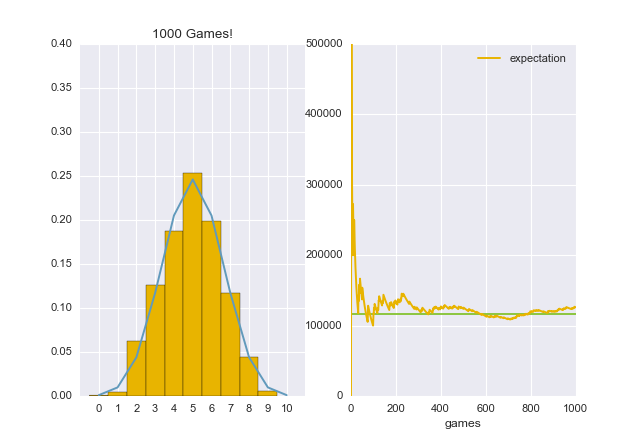

Monte Carlo converging at 0.0100010001%
Error to closed-form solution at 3.59466666667%


In [81]:
fig, ax, ax2 = anim_init()
ani = animation.FuncAnimation(fig, update_hist, number_of_frames, fargs=(data,), repeat=False )
plt.show()
print "Monte Carlo converging at %s%s" %(abs(100* expectation.tail(2).pct_change().values[1,0]),"%")
print "Error to closed-form solution at %s%s" %(abs(100*(expectation.tail(1).values[0,1] - E)/E),"%")

<br/>
<br/>
<br/>
<br/>
<br/>

# Relive Traffic Nightmares

1-Lane Nagel-Schreckenberg Model

In [82]:
def rules(car, track,v_max,p,nspots):
    v = track[car]
    if v < v_max: #increase speed if less than max
        v += 1
    crash = [d-1 for d in range(1,v+1) if track[(car+d)%nspots]>-1] #don't hit these cars
    if crash:
        v = crash[0]
    if v > 0 and np.random.random() < p: #randomly slow down sometimes FOR NO REASON
        v -= 1
    return v

In [ ]:
def update(track,nspots,v_max,p):
    newtrack = [-1] * nspots
    for spot, v in enumerate(track):
        if v > -1: #this is a car!
            v_new = rules(spot,track,v_max,p,nspots)
            newtrack[(spot+v_new)%nspots] = v_new
    return newtrack

def traffic_flow(N,ncars,nspots,v_max,p,uniform,burn):
    
    tracks = [[0] * ncars + [-1] * (nspots - ncars)]
    if uniform: #uniform spacing
        tracks = np.array(([0]+[-1] * (nspots/ncars - 1))*ncars)
        tracks = [list(np.lib.pad(tracks,(nspots-len(tracks),0),'constant',constant_values=(-1)))]
    if burn:
        tracks = [[0] * ncars + [-1] * (nspots - ncars)]
        for time in range(1000): #burn in
            tracks += [update(tracks[-1],nspots,v_max,p)]
        tracks = [tracks[-1]]



    for time in range(N-1): #generate runs
        tracks += [update(tracks[-1],nspots,v_max,p)]
    
    grad_traffic = np.array(tracks) + 1
    iscar = lambda v: 1 if v >= 0 else 0
    vfunc = np.vectorize(iscar)
    gradcar = lambda v: v if v > 0 else -2
    vgrad = np.vectorize(gradcar)
    traffic = vfunc(np.array(tracks))
    grad_traffic = vgrad(grad_traffic)
    
    #colours for each car
    cols = np.array(tracks) + 1
    cols = np.array([vels[vels.nonzero()] for vels in cols])
    cols -= 1

    #cast into circular coords
    x = np.linspace(2*np.pi,0,nspots,endpoint=False)
    mapped = traffic * x[::-1]
    trimmed = [traf[traf.nonzero()] for traf in mapped]

    green = Color("red")
    darkgreen = Color('#006400')
    gradient = list(green.range_to(darkgreen,v_max+1))
    colours = [[gradient[v].rgb for v in vels] for vels in cols]

    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(grad_traffic,interpolation='none',cmap='Greens', aspect = 'auto')
    ax.set_ylabel('time')
    ax.set_xlabel('distance')
    ax.set_title('Traffic Flow (Nagel-Schreckenberg)')
    ax.grid(False)
    plt.show()

    return trimmed, colours

In [ ]:
def traff_init(trimmed,colours,size=7):
    fig,ax = plt.subplots(frameon=False,figsize=(size,size))
    ax.axis('equal')
    ax.axis('off')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylim([-1.1,1.1])
    ax.set_xlim([-1.1,1.1])
    ax.scatter(np.sin(trimmed[0]),np.cos(trimmed[0]), color=colours[0],alpha=0.7,s=10*size)
    return fig, ax
def animate(i,size=7):
    ax.cla()
    ax.axis('equal')
    ax.axis('off')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylim([-1.1,1.1])
    ax.set_xlim([-1.1,1.1])
    ax.scatter(np.sin(trimmed[i]),np.cos(trimmed[i]), color=colours[i],alpha=0.7,s=10*size)

## One Car
Cars travel left to right, and loop back around. Each step downward is an iteration in time.
- Try this with different values of $p$

<IPython.core.display.Javascript object>


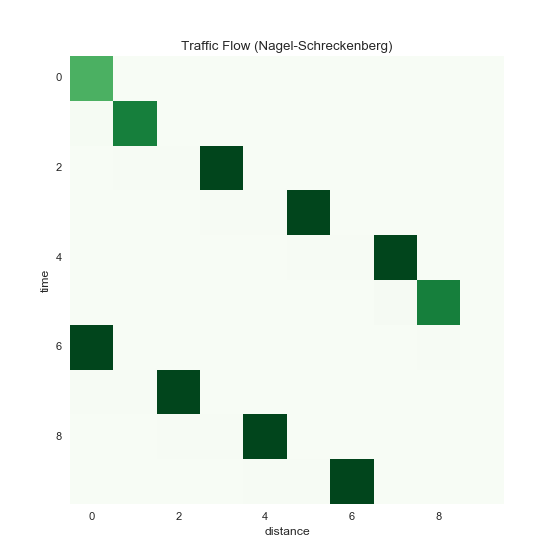

In [85]:
trimmed = traffic_flow(N = 10, ncars = 1, nspots = 10, v_max = 2, p = 0.3, burn = False, uniform = False, )

<br/>
<br/>
<br/>
<br/>
<br/>

## Many Cars

<IPython.core.display.Javascript object>


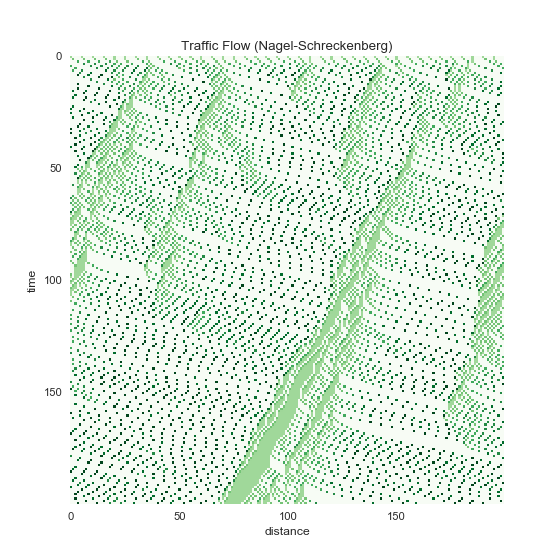

In [86]:
trimmed,colours=traffic_flow(ncars=40,nspots=200,v_max=5,p=0.33,uniform=True,N=200,burn=False, )

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

Driving

<IPython.core.display.Javascript object>


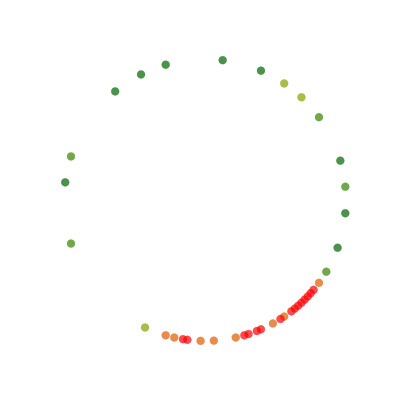

In [87]:
size = 5 
fig, ax = traff_init(trimmed,colours,size)
circ = animation.FuncAnimation(fig, animate, len(trimmed), fargs=(size,), repeat=False,interval = 200)
plt.show()

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

# Toy Model Again

In general, toy models like we saw before are scaled up to include more parameters, to:

* Calibrate to [**Market Data**](#What-Historical-Data-do-we-use?) (historical prices, indexes, interest rates, the sentiments of Donald Trump's tweets, ...)
* Calculate [**Greeks**](#Greeks) (effects of small changes on input params)
* More accurately hedge risk

Plotting Monte Carlo runs allows easy visualisation of the effect of changes in parameters

## Toy Disclaimer for the Toy Model

Please don't blame me if you lose all your money using this toy model.

### What Historical Data do we use?

Consider **TD Bank** Stocks. We can look at three time periods that produce very different results

1. Lots of History (2007-2017) 
2. Recent History (2016-2017)
3. Last Month (March 2017)

Last Ten Years

In [88]:
run_data = []
historical_data=[]
symbol = "TD"
t_end = 10
history, mean, vol = get_history(symbol,'2007-01-01','2017-01-01')
run_data += [gen_runs(50,mean,vol,history,t_end)]; historical_data += [history]

Last Year

In [89]:
history, mean, vol = get_history(symbol,'2016-01-02','2017-01-01')
run_data += [gen_runs(50,mean,vol,history,t_end)]; historical_data += [history]

Last Month

In [90]:
history, mean, vol = get_history(symbol,'2017-03-01','2017-03-31')
run_data += [gen_runs(50,mean,vol,history,t_end)]; historical_data += [history]

Comparing Input Data

<IPython.core.display.Javascript object>


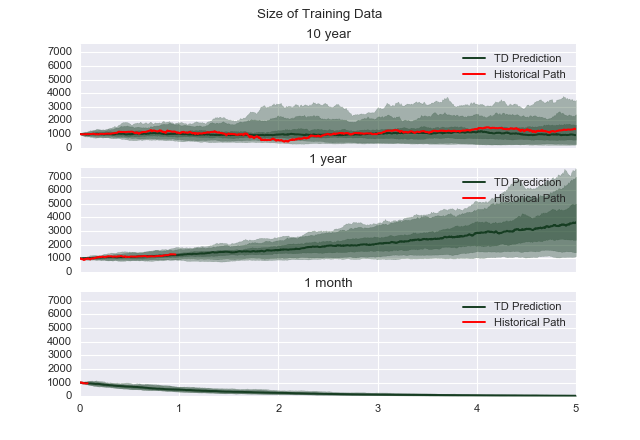

In [93]:
end_plot(run_data,historical_data,t_f = 5,hist=True, names=['10 year','1 year','1 month'],title='Size of Training Data')

<br/>
<br/>
<br/>
<br/>
<br/>

## Greeks

A set of derivatives which describe how option values change with changes in market data. The big three first-order derivatives are:

- $\Delta$ Delta - Sensitivity to **underlying price**
    - We can get an idea of this by shifting our mean and re-running the Monte Carlo
- $\nu$ Vega - Sensitivity to **volatility**
    - We can get an idea of this by shifting our volatility and re-running the Monte Carlo
- $\Theta$ Theta - Sensitivity to **time**
    - We already have an idea of this from our time evolution of the underlying
    

There are also a large potato sack's worth of other first, second and third-order derivatives (derivatives of derivatives of derivatives!) that you could go a lifetime not thinking about

In [ ]:
symbol='TD'
N=1000
meanshift = 0.1 * 0.01
volshift = 50*0.01

def shock(shift,run_data,meanshift=meanshift,volshift=volshift,N=100):
    if shift == "vegashift":
        meanshift = 0
    elif shift == 'deltashift':
        volshift = 0
    run_data += [gen_runs(N,mean*(meanshift + 1),vol *(volshift + 1),history,t_end)]
    run_data += [gen_runs(N,mean/(meanshift + 1),vol/(volshift + 1),history,t_end)]    
    run_data = run_data [-1:] + run_data[:-1]
    return run_data

### Delta

<IPython.core.display.Javascript object>


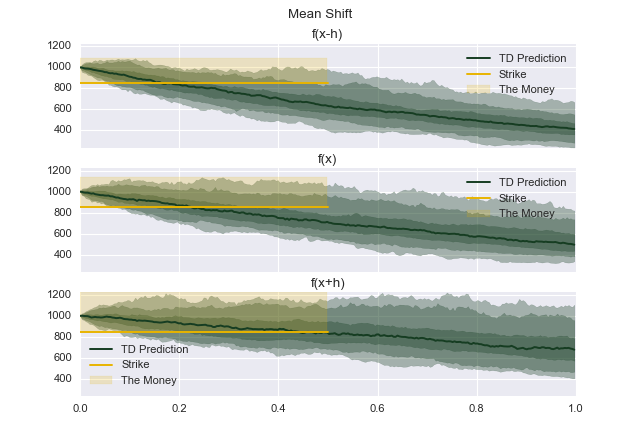

In [94]:
#history, mean, vol = get_history(symbol,'2016-01-02','2017-01-01')
delta_data = shock("deltashift",run_data=[gen_runs(N,mean,vol,history,t_end)])
end_plot(delta_data,historical_data,strike = 850, expiry = 0.5, title='Mean Shift',callput='call',t_f = 1,hist=False, names=['f(x-h)','f(x)','f(x+h)'],bands = bands)

<br/>
<br/>
<br/>
<br/>
<br/>

### Vega

<IPython.core.display.Javascript object>


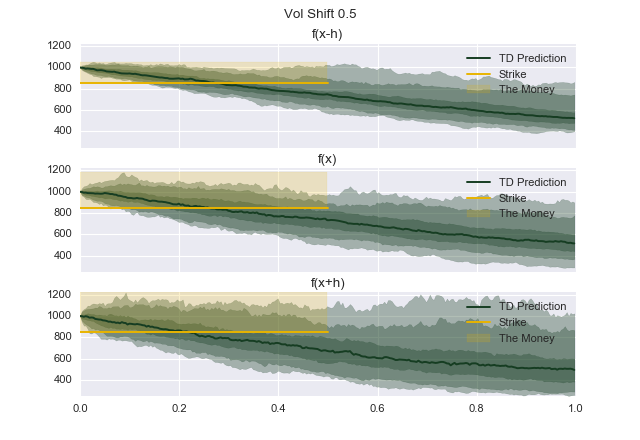

In [95]:
vega_data = shock("vegashift",run_data=[gen_runs(N,mean,vol,history,t_end)])
end_plot(vega_data,historical_data, strike = 850, expiry = 0.5, callput='call',t_f = 1,hist=False, names=['f(x-h)','f(x)','f(x+h)'], title="Vol Shift %s"%(volshift))

<br/>
<br/>
<br/>
<br/>
<br/>

# The Power of Monte Carlo

- Replacing uncertain variables with probability distributions, models can account for inherent uncertainty

- By sampling probability distributions, we explore possible outcomes and account for risk within the model 

- Possible to find results for problems where no analytic (or elegant) solutions are known

## Questions ... ?